# **Autoencoders Variacionais - MNIST - PyTorch**

Neste *notebook*: 
- Implementaremos autoencoders variocionais com camadas  *fully-connected* para obtenção de modelos generativos capazes de sintetizar imagens de dígitos manuscritos similares aos do *dataset* MNIST
- Investigaremos o impacto da dimensão do espaço latente e de algumas funções de perda sobre a qualidade tanto das imagens de treinamento reconstruídas quanto das novas imagens geradas
- Por fim, visualizaremos o *manifold* aprendido pelo modelo


### **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm 
import time
import torch
import torch.nn.functional as F

from torch import nn, optim
from torchvision import datasets, transforms
from google.colab import drive

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

!nvidia-smi

drive.mount('/content/gdrive')

Usando: cuda
Fri Nov 20 14:45:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    14W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                           

### **Preparação dos dados**

**Download do dataset**

Primeiro fazemos o *download* dos dados de treinamento do MNIST  utilizando o *torchvision.datasets*.

Aplicamos um *transforms.ToTensor()* para converter as imagens de dígitos manuscritos do formato *PIL Image* para o formato *torch.tensor*. Além disso, esse método normaliza os pixels de entrada, inicialmente no intervalo [0, 255], para o intervalo [0, 1].

A classe *dataset* do PyTorch é o principal parâmetro da classe *DataLoader*, cuja função é criar o conjunto de mini-batches que serão iterados durante o treinamento do modelo.

In [2]:
transform = transforms.ToTensor() 
train_dataset = datasets.MNIST(root='MNIST/processed/training.pt', train=True, download=True, transform=transform)

print('data.shape   : ', train_dataset.data.shape)
print('targets.shape: ', train_dataset.targets.shape)

Extracting MNIST/processed/training.pt/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/processed/training.pt/MNIST/raw


Extracting MNIST/processed/training.pt/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/processed/training.pt/MNIST/raw


Extracting MNIST/processed/training.pt/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/processed/training.pt/MNIST/raw




Extracting MNIST/processed/training.pt/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/processed/training.pt/MNIST/raw
Processing...
Done!
data.shape   :  torch.Size([60000, 28, 28])
targets.shape:  torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**DataLoaders**

A classe *DataLoader* quando aplicado ao *dataset* retorna um iterável com cada elemento contendo um *mini-batch*.

In [3]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # A cada época os mini-batches são apresentados numa sequência diferente
print(f'{len(train_dataloader)} mini-batches de {BATCH_SIZE} amostras para treinamento')

1875 mini-batches de 32 amostras para treinamento


**Visualização de amostras de treinamento**

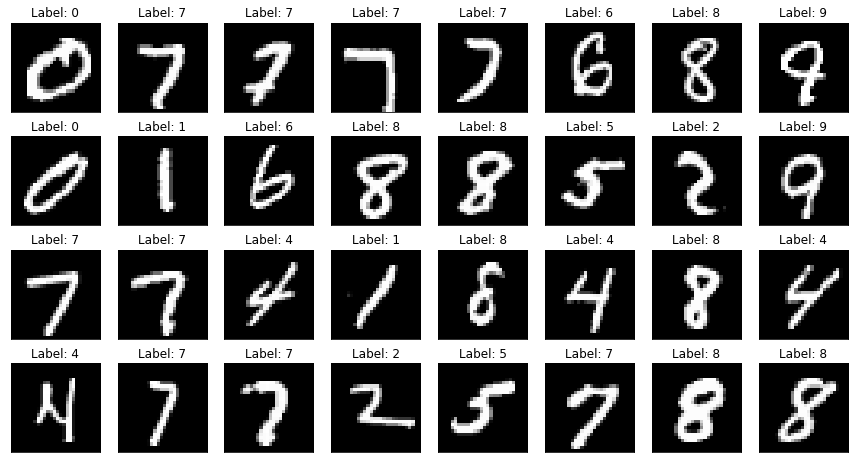

In [4]:
images, labels = next(iter(train_dataloader))
fig = plt.figure(figsize=(15, 8))

for i, image, label in zip(range(32), images, labels):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title(f'Label: {label}')
    plt.xticks([])
    plt.yticks([])

### **Arquitetura do autoencoder variacional**

Aqui pegamos um *batch* que será passado por cada módulo do autoencoder variacional para verificar se o seu funcionamento está correto. Consideramos que a dimensão do espaço latente é igual a 2.

In [5]:
INPUT_DIM = 784
LATENT_DIM = 2

batch, labels = next(iter(train_dataloader))         # retorna um batch de 32 amostras
batch = batch.squeeze(1).view(batch.shape[0], -1)    # altera o shape do batch: (32, 1, 28, 28) -> (32, 28, 28) -> (32, 784)

# Apenas para verificar se os dados estão normalizados
print('batch.max: ', batch.max())
print('batch.min: ', batch.min())

batch.max:  tensor(1.)
batch.min:  tensor(0.)


**Codificador (Encoder)**

O encoder com camadas *fully-connected* tem a seguinte estrutura:

| Camada | Nº neurônios | Nº inputs | Função |
|--------|-----------------|--------|-|
|Linear1|512|784|(B, 784) -> (B, 512)|
|ReLU|-|-|Não-linearidade|
|Linear2|256|512|(B, 512) -> (B, 256)|
|ReLU|-|-|Não-linearidade|
|Dropout|-|-|Regularização - Taxa de 30%|
|Linear_mean|2|256|(B, 256) -> (B, 2): Vetor de médias|
|Linear_logvar|2|256|(B, 256) -> (B, 2): Vetor de log das variâncias|


In [6]:
class VariationalEncoderMLP(nn.Module):
    def __init__(self, in_features, latent_dim):
        super(VariationalEncoderMLP, self).__init__()
        self.in_features = in_features
        self.latent_dim = latent_dim

        self.linear1 = nn.Linear(self.in_features, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear_mean = nn.Linear(256, self.latent_dim)
        self.linear_logvar = nn.Linear(256, self.latent_dim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):                                # B = BATCH_SIZE
        x = F.relu(self.linear1(x))                      # (B, 784) -> (B, 512)
        x = self.dropout(F.relu(self.linear2(x)))        # (B, 512) -> (B, 256)
        x_mean = self.linear_mean(x)                     # (B, 256) -> (B, INPUT_DIM)
        x_logvar = self.linear_logvar(x)                 # (B, 256) -> (B, INPUT_DIM)
        return x_mean, x_logvar


# Passamos o batch para verificar o funcionamento
model = VariationalEncoderMLP(in_features=INPUT_DIM, latent_dim=LATENT_DIM)
mean, logvar = model(batch)

print('batch.shape : ', batch.shape)
print('mean.shape  : ', mean.shape)
print('logvar.shape: ', logvar.shape)

batch.shape :  torch.Size([32, 784])
mean.shape  :  torch.Size([32, 2])
logvar.shape:  torch.Size([32, 2])


**Truque da Reparametrização**


In [7]:
class ReparametrizationTrick(nn.Module):
    def __init__(self, latent_dim):
        super(ReparametrizationTrick, self).__init__()
        self.latent_dim = latent_dim
        self.register_buffer('gaussian_noise', torch.randn(self.latent_dim, requires_grad=False).squeeze(0))

    def forward(self, x_mean, x_logvar):                                 # x_mean.shape = (B, latent_dim) x_logvar.shape = (B, latent_dim)
        x = (self.gaussian_noise * torch.exp(x_logvar / 2)) + x_mean     # x.shape = (B, latent_dim)
        return x


# Passamos o batch para verificar o funcionamento
model = ReparametrizationTrick(latent_dim=LATENT_DIM)
code_samples = model(mean, logvar)

print('batch.shape : ', batch.shape)
print('mean.shape  : ', mean.shape)
print('logvar.shape: ', logvar.shape)
print('code_samples.shape: ', code_samples.shape)

batch.shape :  torch.Size([32, 784])
mean.shape  :  torch.Size([32, 2])
logvar.shape:  torch.Size([32, 2])
code_samples.shape:  torch.Size([32, 2])


**Decodificador (Decoder)**

O decoder com camadas *fully-connected* tem a seguinte estrutura:

| Camada | Nº neurônios | Nº inputs | Função |
|--------|-----------------|--------|-|
|Linear1|256|2|(B, 2) -> (B, 256)|
|ReLU|-|-|Não-linearidade|
|Linear2|512|256|(B, 256) -> (B, 512)|
|ReLU|-|-|Não-linearidade|
|Dropout|-|-|Regularização - Taxa de 30%|
|Output|784|512|(B, 512) -> (B, 784)|
|Sigmoid|-|-|Saídas no intervalo [0, 1]|

In [8]:
class VariationalDecoderMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super(VariationalDecoderMLP, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.linear1 = nn.Linear(self.in_features, 256)
        self.linear2 = nn.Linear(256, 512)
        self.output = nn.Linear(512, self.out_features)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):                     
        x = F.relu(self.linear1(x))                        # (B, INPUT_DIM) -> (B, 256)
        x = self.dropout(F.relu(self.linear2(x)))          # (B, 256) -> (B, 512)
        x = torch.sigmoid(self.output(x))                  # (B, 512) -> (B, 784)
        return x


# Passamos o batch para verificar o funcionamento
model = VariationalDecoderMLP(in_features=LATENT_DIM, out_features=INPUT_DIM)
reconstruction = model(code_samples)

print('batch.shape : ', batch.shape)
print('mean.shape  : ', mean.shape)
print('logvar.shape: ', logvar.shape)
print('code_samples.shape: ', code_samples.shape)
print('reconstruction.shape: ', reconstruction.shape)

batch.shape :  torch.Size([32, 784])
mean.shape  :  torch.Size([32, 2])
logvar.shape:  torch.Size([32, 2])
code_samples.shape:  torch.Size([32, 2])
reconstruction.shape:  torch.Size([32, 784])


**Autoencoder Variacional**


In [9]:
class VariationalAutoencoderMLP(nn.Module):
    def __init__(self, in_features, latent_dim):
        super(VariationalAutoencoderMLP, self).__init__()
        self.in_features = in_features
        self.latent_dim = latent_dim

        self.encoder = VariationalEncoderMLP(self.in_features, self.latent_dim)
        self.sampling = ReparametrizationTrick(self.latent_dim)
        self.decoder = VariationalDecoderMLP(self.latent_dim, self.in_features)
   
    def forward(self, x):                                 
        x_mean, x_logvar = self.encoder(x)            # (B, 784) -> 2 x (B, INPUT_DIM)
        x_codes = self.sampling(x_mean, x_logvar)     # 2 x (B, INPUT_DIM) -> (B, INPUT_DIM)
        x_reconstruction = self.decoder(x_codes)      # (B, INPUT_DIM) -> (B, 784)
        return x_reconstruction, x_mean, x_logvar

model = VariationalAutoencoderMLP(in_features=INPUT_DIM, latent_dim=LATENT_DIM)

reconstruction, mean, logvar = model(batch)
print('batch.shape : ', batch.shape)
print('mean.shape  : ', mean.shape)
print('logvar.shape: ', logvar.shape)
print('reconstruction.shape  : ', reconstruction.shape)

batch.shape :  torch.Size([32, 784])
mean.shape  :  torch.Size([32, 2])
logvar.shape:  torch.Size([32, 2])
reconstruction.shape  :  torch.Size([32, 784])


### **Função Custo**

A função custo do autoencoder variacional é composta por duas parcelas: o erro de reconstrução e o erro de regularização.

**Erro de Reconstrução**

O erro de reconstrução compara as imagens reconstruídas com as imagens de entrada, medindo a diferença pixel a pixel de ambas as imagens. Dentre as diversas funções custo testaremos o Erro Quadrático Médio (*MSE Loss*), Erro Absoluto Médio (*MAE Loss* ou *L1 Loss*) e a Entropia Cruzada (*BCE Loss*).

In [10]:
criterion_BCE = nn.BCELoss(reduction='mean')
criterion_MSE = nn.MSELoss(reduction='mean')
criterion_MAE = nn.L1Loss(reduction='mean') 

BCE_loss = criterion_BCE(reconstruction, batch)
MSE_loss = criterion_MSE(reconstruction, batch)
MAE_loss = criterion_MAE(reconstruction, batch)
print('BCE_loss: ', BCE_loss.item())
print('MSE_loss: ', MSE_loss.item())
print('MAE_loss: ', MAE_loss.item())

BCE_loss:  0.6927962899208069
MSE_loss:  0.2315560132265091
MAE_loss:  0.4720969796180725


**Erro de Regularização (Divergente de Kullback-Leibler)**

O erro de regularização mede o quão "distante" a distribuição à posteriori do espaço latente está da distribuição à priori imposta (normal de média zero e desvio padrão unitário). Como as duas distribuições são normais, o divergente de Kullback-Leibler possui forma fechada e é dada pela expressão abaixo. 

In [11]:
def KLDLoss(mean, logvar):
    loss = - 0.5 * torch.sum(1 + logvar - torch.exp(logvar) - mean*mean, dim=-1) 
    loss = torch.mean(loss) / 784.
    return loss

regularization_loss = KLDLoss(mean, logvar)
print('regularization_loss: ', regularization_loss.item())

regularization_loss:  2.4143776045093546e-06


### **Funções auxiliares**

**Função de treinamento**

In [12]:
@torch.enable_grad()
def train(dataloader, model, reconstruction_loss, regularization_loss, optimizer, device, running_epoch, total_epoch):
    # progressbar para o treinamento
    progressbar = tqdm.notebook.tqdm(range(len(dataloader)), 
                                     desc=f'Epoch: {running_epoch}/{total_epoch} - batch_step:', 
                                     bar_format='{desc}|{bar}|{n_fmt}/{total_fmt} ')
                                     
    running_loss = 0
    model.train()

    start_time = time.time() # inicia a contagem de tempo do treinamento na época
    for (image, _), i in zip(dataloader, progressbar):
        image = image.squeeze(1).view(image.shape[0], -1).to(device)     # image.shape: (B, 1, 28, 28) -> (B, 784)
        reconstruction, mean, logvar = model(image)                      # Etapa forward: passagem do batch ao longo do modelo
        loss = reconstruction_loss(reconstruction, image) + regularization_loss(mean, logvar) # Custo associado ao batch
        running_loss += loss.item()
        optimizer.zero_grad()                   # Zera os gradientes (por default no Pytorch os gradientes são cumulativos)
        loss.backward()                         # Etapa backward: error backpropagation -> obtem o gradiente
        optimizer.step()                        # Etapa de ajuste dos pesos
    
    stop_time = time.time() # finaliza a contagem de tempo do treinamento na época
    total_time = stop_time - start_time
    train_loss = running_loss / len(dataloader)
    return train_loss, progressbar, total_time

**Função main**

In [13]:
def main(train_dataloader, model, reconstruction_loss, regularization_loss, optimizer, device, epoch):
    
    train_losses = []
    for e in range(1, epoch+1):
        train_loss, pbar, tottime = train(dataloader=train_dataloader,
                                          model=model,
                                          reconstruction_loss=reconstruction_loss,
                                          regularization_loss=regularization_loss,
                                          optimizer=optimizer,
                                          device=device, 
                                          running_epoch=e,
                                          total_epoch=epoch)
        
        pbar.write(end=' ', s='---> Epoch_time: {} s'. format(int(tottime)) + '  -  step_time: {:.2f} ms'.format(1000*tottime/len(train_dataloader)) + '  -  train_loss: {:.4f}'.format(train_loss))
        train_losses.append(train_loss)
    return train_losses

**Função auxiliar para separar a visualização das imagens**

In [14]:
def separa_imagens(N, hyperparam, opt):
    space_image = torch.ones(28, 2800)
    space_image[0][0] = 0
    fig = plt.figure(num=N, figsize=(1, 20))
    plt.imshow(space_image, cmap='gray')
    if opt == 'latent_dim':
        plt.title(f'Imagens geradas pelo decoder do VAE-MLP com espaço latente de dimensão {hyperparam}')
    if opt == 'criterion':
        plt.title(f'Imagens geradas pelo decoder do VAE-MLP com erro de reconstrução {hyperparam}')
    plt.xticks([])
    plt.yticks([])

### **Análise - Dimensão do Espaço Latente**

**Instâncias do modelo, da função custo e do otimizador**

Primeiro treinaremos autoencoders variacionais com espaço latente de diferentes dimensões para analisar como este hiperparâmetro influencia tanto nas imagens reconstruídas pelo modelo quanto na geração de novas imagens. Para isso, consideraremos espaços latentes de dimensões iguais a 2, 10 e 50.

A escolha da melhor dimensão do espaço latente é feita a partir da análise visual das imagens geradas pelos decodificadores treinados. Consideraremos como melhor dimensão aquela associada ao decodificador que produzir as imagens mais similares aos do dataset.

Os modelos são treinados por 30 épocas com mini-batches de 32 amostras, o algoritmo de otimização para ajuste dos pesos é o Adam com configuração *default* e a função custo de reconstrução utilizada, a mais encontrada na literatura para este problema, é a *BCE Loss*.

In [15]:
BATCH_SIZE = 32
EPOCHS = 30
INPUT_DIM = 784
LATENT_DIMS = [2, 10, 50]
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

MLP_VAEs = [VariationalAutoencoderMLP(in_features=INPUT_DIM, latent_dim=LATENT_DIM).to(device) for LATENT_DIM in LATENT_DIMS]
optimizers = [optim.Adam(MLP_VAE.parameters()) for MLP_VAE in MLP_VAEs]

criterion1 = nn.BCELoss()
criterion2 = KLDLoss

**Funcionamento do decoder antes do treinamento**

Antes verificamos o que cada decodificador está produzindo como saída. Note que as imagens são simplesmente ruídos.

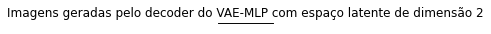

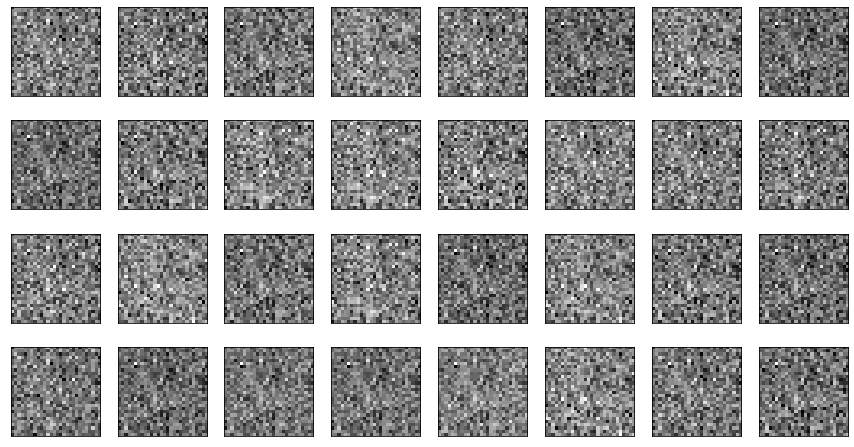

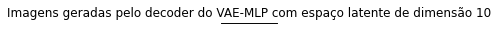

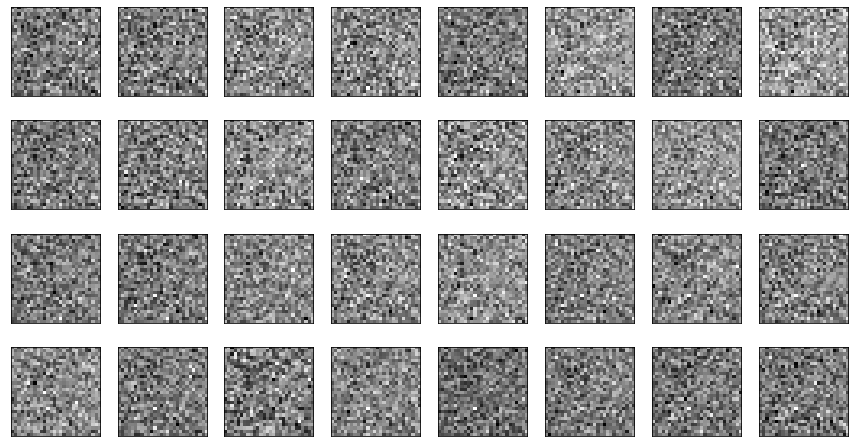

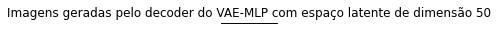

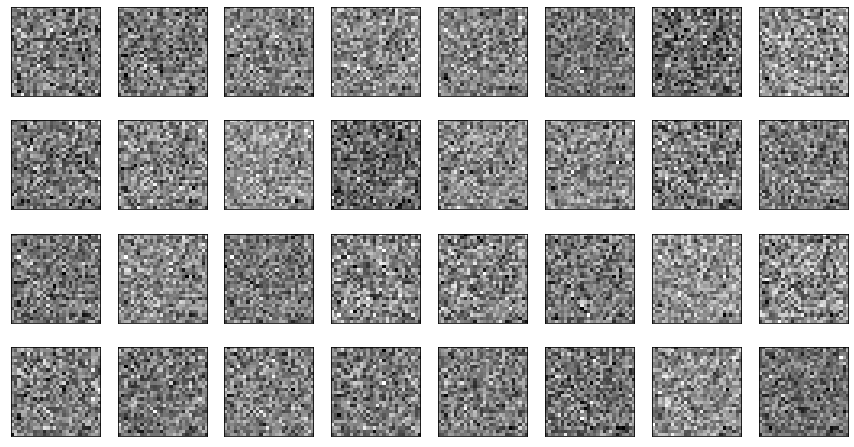

In [16]:
N = 0
for LATENT_DIM, MLP_VAE in zip(LATENT_DIMS, MLP_VAEs):
    MLP_VAE.eval() 
    gaussian_noise = torch.randn(BATCH_SIZE, LATENT_DIM)
    decoder = MLP_VAE.decoder

    new_images = decoder(gaussian_noise.to(device))
    
    separa_imagens(N=N, hyperparam=LATENT_DIM, opt='latent_dim'); N += 1
    fig = plt.figure(num=N, figsize=(15, 8)); N += 1

    with torch.no_grad():
        for i, new_image in enumerate(new_images):
            fig.add_subplot(4, 8, i+1)
            plt.imshow(new_image.view(28, 28).cpu(), cmap='gray')
            plt.xticks([])
            plt.yticks([])

**Treinamento**


In [17]:
models = []
for N, MLP_VAE, optimizer, LATENT_DIM in zip(range(3), MLP_VAEs, optimizers, LATENT_DIMS):
    info = 'Treinamento do VAE-MLP com espaço latente de dimensão ' + str(LATENT_DIM)
    info = info.center(len(info) + 40)
    print()
    print(len(info)*'=')
    print(info)
    print(len(info)*'=')
    main(train_dataloader=train_dataloader,
         model=MLP_VAE,
         reconstruction_loss=criterion1,
         regularization_loss=criterion2,
         optimizer = optimizer,
         device=device,
         epoch=EPOCHS);
    models.append(MLP_VAE)


                    Treinamento do VAE-MLP com espaço latente de dimensão 2                    


---> Epoch_time: 14 s  -  step_time: 7.69 ms  -  train_loss: 0.2102 

---> Epoch_time: 14 s  -  step_time: 7.73 ms  -  train_loss: 0.1934 

---> Epoch_time: 14 s  -  step_time: 7.70 ms  -  train_loss: 0.1895 

---> Epoch_time: 14 s  -  step_time: 7.65 ms  -  train_loss: 0.1875 

---> Epoch_time: 14 s  -  step_time: 7.70 ms  -  train_loss: 0.1856 

---> Epoch_time: 14 s  -  step_time: 7.64 ms  -  train_loss: 0.1849 

---> Epoch_time: 13 s  -  step_time: 7.46 ms  -  train_loss: 0.1842 

---> Epoch_time: 14 s  -  step_time: 7.53 ms  -  train_loss: 0.1835 

---> Epoch_time: 13 s  -  step_time: 7.44 ms  -  train_loss: 0.1832 

---> Epoch_time: 14 s  -  step_time: 7.47 ms  -  train_loss: 0.1830 

---> Epoch_time: 13 s  -  step_time: 7.36 ms  -  train_loss: 0.1830 

---> Epoch_time: 13 s  -  step_time: 7.31 ms  -  train_loss: 0.1821 

---> Epoch_time: 13 s  -  step_time: 7.23 ms  -  train_loss: 0.1818 

---> Epoch_time: 13 s  -  step_time: 7.21 ms  -  train_loss: 0.1816 

---> Epoch_time: 13 s  -  step_time: 7.25 ms  -  train_loss: 0.1811 

---> Epoch_time: 13 s  -  step_time: 7.30 ms  -  train_loss: 0.1809 

---> Epoch_time: 13 s  -  step_time: 7.26 ms  -  train_loss: 0.1809 

---> Epoch_time: 13 s  -  step_time: 7.15 ms  -  train_loss: 0.1807 

---> Epoch_time: 13 s  -  step_time: 7.19 ms  -  train_loss: 0.1802 

---> Epoch_time: 13 s  -  step_time: 7.33 ms  -  train_loss: 0.1804 

---> Epoch_time: 13 s  -  step_time: 7.23 ms  -  train_loss: 0.1803 

---> Epoch_time: 13 s  -  step_time: 7.28 ms  -  train_loss: 0.1799 

---> Epoch_time: 13 s  -  step_time: 7.30 ms  -  train_loss: 0.1804 

---> Epoch_time: 13 s  -  step_time: 7.30 ms  -  train_loss: 0.1800 

---> Epoch_time: 13 s  -  step_time: 7.46 ms  -  train_loss: 0.1795 

---> Epoch_time: 13 s  -  step_time: 7.39 ms  -  train_loss: 0.1793 

---> Epoch_time: 13 s  -  step_time: 7.39 ms  -  train_loss: 0.1796 

---> Epoch_time: 13 s  -  step_time: 7.46 ms  -  train_loss: 0.1792 

---> Epoch_time: 13 s  -  step_time: 7.38 ms  -  train_loss: 0.1790 

---> Epoch_time: 13 s  -  step_time: 7.15 ms  -  train_loss: 0.1789 
                    Treinamento do VAE-MLP com espaço latente de dimensão 10                    


---> Epoch_time: 13 s  -  step_time: 7.28 ms  -  train_loss: 0.1737 

---> Epoch_time: 13 s  -  step_time: 7.19 ms  -  train_loss: 0.1424 

---> Epoch_time: 13 s  -  step_time: 7.20 ms  -  train_loss: 0.1369 

---> Epoch_time: 13 s  -  step_time: 7.30 ms  -  train_loss: 0.1343 

---> Epoch_time: 13 s  -  step_time: 7.18 ms  -  train_loss: 0.1325 

---> Epoch_time: 13 s  -  step_time: 7.22 ms  -  train_loss: 0.1313 

---> Epoch_time: 13 s  -  step_time: 7.13 ms  -  train_loss: 0.1304 

---> Epoch_time: 13 s  -  step_time: 7.21 ms  -  train_loss: 0.1297 

---> Epoch_time: 13 s  -  step_time: 7.11 ms  -  train_loss: 0.1290 

---> Epoch_time: 13 s  -  step_time: 7.16 ms  -  train_loss: 0.1286 

---> Epoch_time: 13 s  -  step_time: 7.01 ms  -  train_loss: 0.1281 

---> Epoch_time: 13 s  -  step_time: 7.06 ms  -  train_loss: 0.1277 

---> Epoch_time: 13 s  -  step_time: 7.11 ms  -  train_loss: 0.1274 

---> Epoch_time: 13 s  -  step_time: 7.39 ms  -  train_loss: 0.1272 

---> Epoch_time: 14 s  -  step_time: 7.47 ms  -  train_loss: 0.1268 

---> Epoch_time: 14 s  -  step_time: 7.49 ms  -  train_loss: 0.1268 

---> Epoch_time: 13 s  -  step_time: 7.45 ms  -  train_loss: 0.1265 

---> Epoch_time: 13 s  -  step_time: 7.40 ms  -  train_loss: 0.1263 

---> Epoch_time: 13 s  -  step_time: 7.33 ms  -  train_loss: 0.1260 

---> Epoch_time: 13 s  -  step_time: 7.36 ms  -  train_loss: 0.1259 

---> Epoch_time: 14 s  -  step_time: 7.50 ms  -  train_loss: 0.1258 

---> Epoch_time: 13 s  -  step_time: 7.45 ms  -  train_loss: 0.1257 

---> Epoch_time: 13 s  -  step_time: 7.29 ms  -  train_loss: 0.1255 

---> Epoch_time: 13 s  -  step_time: 7.24 ms  -  train_loss: 0.1254 

---> Epoch_time: 13 s  -  step_time: 7.18 ms  -  train_loss: 0.1253 

---> Epoch_time: 13 s  -  step_time: 7.21 ms  -  train_loss: 0.1251 

---> Epoch_time: 13 s  -  step_time: 7.16 ms  -  train_loss: 0.1251 

---> Epoch_time: 13 s  -  step_time: 7.23 ms  -  train_loss: 0.1250 

---> Epoch_time: 13 s  -  step_time: 7.24 ms  -  train_loss: 0.1250 

---> Epoch_time: 13 s  -  step_time: 7.26 ms  -  train_loss: 0.1247 
                    Treinamento do VAE-MLP com espaço latente de dimensão 50                    


---> Epoch_time: 13 s  -  step_time: 7.11 ms  -  train_loss: 0.1846 

---> Epoch_time: 13 s  -  step_time: 7.03 ms  -  train_loss: 0.1474 

---> Epoch_time: 13 s  -  step_time: 7.10 ms  -  train_loss: 0.1389 

---> Epoch_time: 13 s  -  step_time: 7.16 ms  -  train_loss: 0.1337 

---> Epoch_time: 13 s  -  step_time: 7.20 ms  -  train_loss: 0.1305 

---> Epoch_time: 13 s  -  step_time: 7.03 ms  -  train_loss: 0.1280 

---> Epoch_time: 13 s  -  step_time: 7.07 ms  -  train_loss: 0.1261 

---> Epoch_time: 13 s  -  step_time: 7.07 ms  -  train_loss: 0.1249 

---> Epoch_time: 13 s  -  step_time: 7.16 ms  -  train_loss: 0.1236 

---> Epoch_time: 13 s  -  step_time: 7.09 ms  -  train_loss: 0.1226 

---> Epoch_time: 13 s  -  step_time: 7.05 ms  -  train_loss: 0.1217 

---> Epoch_time: 13 s  -  step_time: 7.10 ms  -  train_loss: 0.1209 

---> Epoch_time: 13 s  -  step_time: 7.06 ms  -  train_loss: 0.1202 

---> Epoch_time: 13 s  -  step_time: 7.16 ms  -  train_loss: 0.1196 

---> Epoch_time: 13 s  -  step_time: 7.16 ms  -  train_loss: 0.1192 

---> Epoch_time: 13 s  -  step_time: 7.09 ms  -  train_loss: 0.1186 

---> Epoch_time: 13 s  -  step_time: 7.04 ms  -  train_loss: 0.1182 

---> Epoch_time: 13 s  -  step_time: 7.04 ms  -  train_loss: 0.1178 

---> Epoch_time: 13 s  -  step_time: 7.03 ms  -  train_loss: 0.1174 

---> Epoch_time: 13 s  -  step_time: 6.97 ms  -  train_loss: 0.1169 

---> Epoch_time: 13 s  -  step_time: 6.96 ms  -  train_loss: 0.1167 

---> Epoch_time: 13 s  -  step_time: 7.07 ms  -  train_loss: 0.1163 

---> Epoch_time: 13 s  -  step_time: 7.04 ms  -  train_loss: 0.1161 

---> Epoch_time: 12 s  -  step_time: 6.91 ms  -  train_loss: 0.1158 

---> Epoch_time: 13 s  -  step_time: 6.94 ms  -  train_loss: 0.1155 

---> Epoch_time: 13 s  -  step_time: 7.01 ms  -  train_loss: 0.1155 

---> Epoch_time: 13 s  -  step_time: 7.05 ms  -  train_loss: 0.1150 

---> Epoch_time: 13 s  -  step_time: 7.12 ms  -  train_loss: 0.1149 

---> Epoch_time: 13 s  -  step_time: 7.01 ms  -  train_loss: 0.1147 

---> Epoch_time: 13 s  -  step_time: 6.96 ms  -  train_loss: 0.1144 

**Exemplos de imagens reconstruídas**

A figura abaixo mostra um *mini-batch* de treinamento com imagens reconstruídas pelos autoencoders variacionais.

Podemos observar que quanto maior a dimensão do espaço latente melhor é o processo de reconstrução das imagens de entrada, o que se deve ao aumento da flexibilidade do modelo. 

Com espaço latente de dimensão 2 as imagens estão com baixíssima resolução e os dígitos estão mais arredondados. Também observamos que há algumas imagens reconstruídas que representam dígitos incorretos.

Por outro lado, com espaços latentes de dimensões iguais a 10 e 50, as imagens estão com uma resolução melhor e os modelos conseguiram capturar bem as particularidades das imagens de entrada.

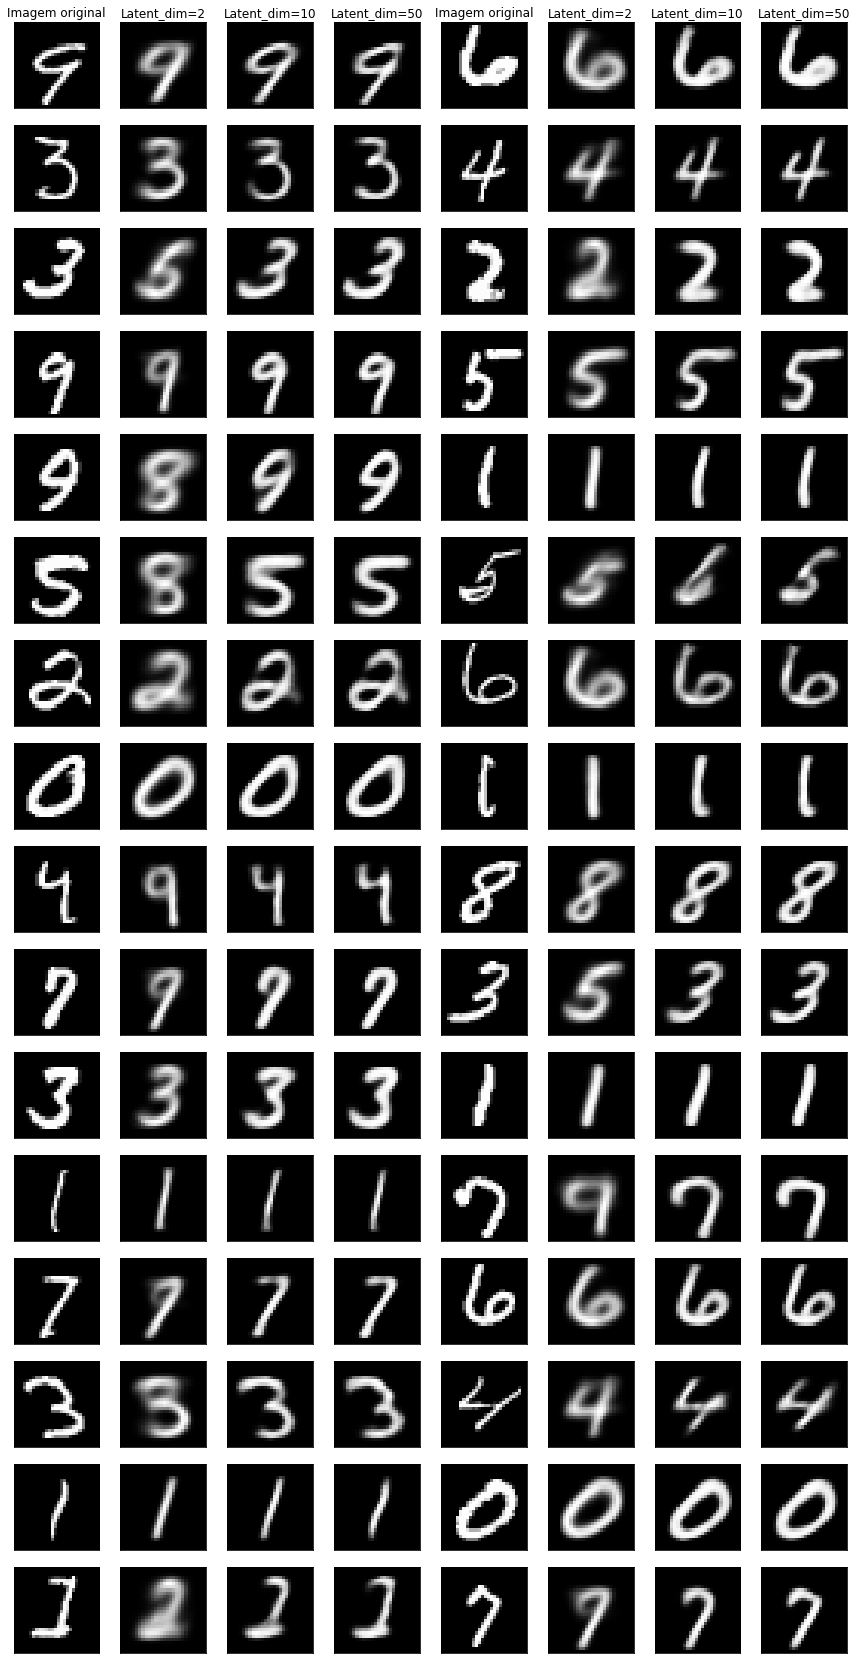

In [18]:
images_examples, labels_example = next(iter(train_dataloader))
images = images_examples.squeeze(1).view(images_examples.shape[0], -1).to(device)

MLP_VAEs[0].eval()
MLP_VAEs[1].eval()
MLP_VAEs[2].eval()

reconstructions = [reconstruction for reconstruction, _, _ in [MLP_VAE(images) for MLP_VAE in MLP_VAEs]]

x = []
for i in range(32):
    x.append(images[i])
    for j in range(3):
        x.append(reconstructions[j][i])

fig = plt.figure(figsize=(15, 30))
with torch.no_grad():
    k = 0
    for i, image in zip(range(128), x):
        fig.add_subplot(16, 8, i+1)
        plt.imshow(image.view(28, 28).cpu(), cmap='gray')
        if i < 8:
            if k == 0:
                plt.title('Imagem original')
                k = 1
            elif k == 1:
                plt.title('Latent_dim=2')
                k = 2
            elif k == 2:
                plt.title('Latent_dim=10')
                k = 3
            else:
                plt.title('Latent_dim=50')
                k = 0
        plt.xticks([]); plt.yticks([])

**Funcionamento do decoder após o treinamento**

A figura abaixo apresenta imagens geradas pelos decodificadores obtidos pelo processo de treinamento, quando submetidos à ruídos gaussianos de média zero e variância unitária.

Diferente das imagens de treinamento reconstruídas, em que o autoencoder variacional com espaço latente de dimensão 2 apresentou o pior desempenho, podemos observar que o modelo generativo deste mesmo autoencoder variacional foi capaz de produzir, em um maior número de vezes, imagens mais similares aos do *dataset*.

O aumento da dimensão do espaço latente levou os modelos generativos a produzir, com uma maior probabilidade, imagens que não são similares aos do *dataset*. Portanto, os autoencoders variacionais com espaços latentes de dimensão 10 e 50 não resultaram em bons modelos generativos.

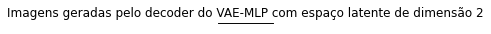

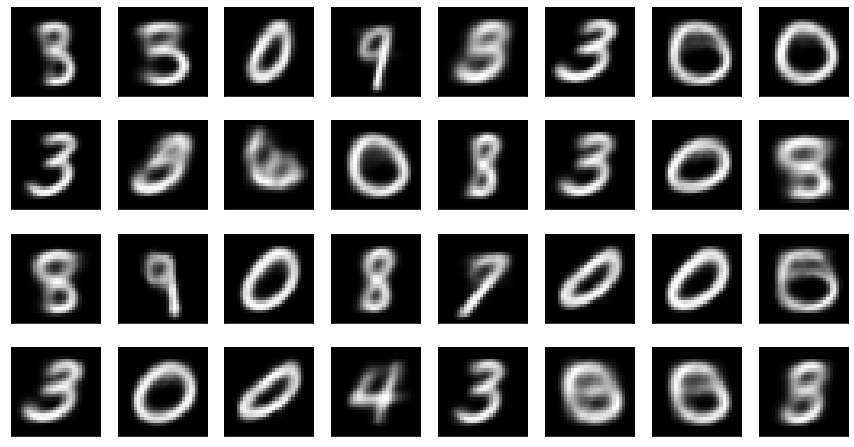

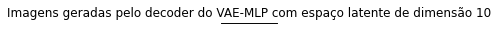

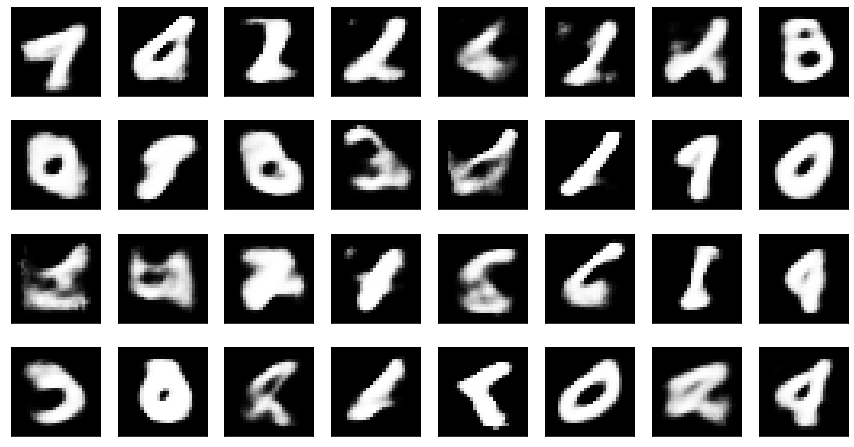

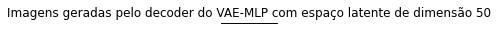

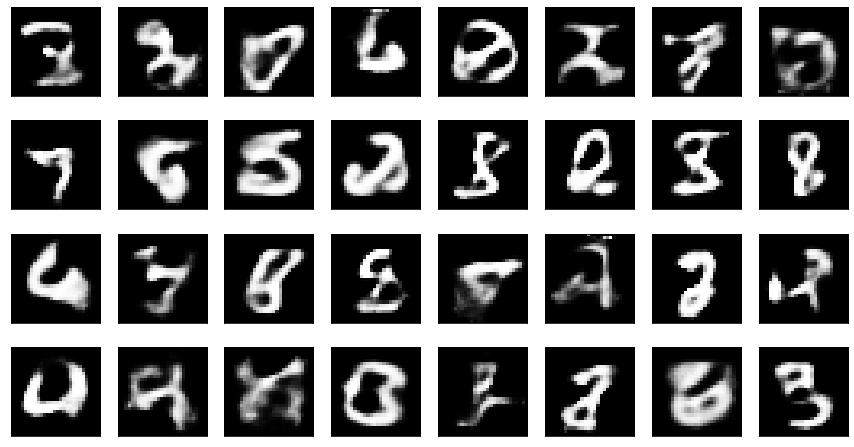

In [19]:
N = 0
for LATENT_DIM, MLP_VAE in zip(LATENT_DIMS, models): 
    gaussian_noise = torch.randn(BATCH_SIZE, LATENT_DIM)
    MLP_VAE.eval()
    decoder = MLP_VAE.decoder

    new_images = decoder(gaussian_noise.to(device))
    image = new_images.view(32, 28, 28).cpu()
    
    separa_imagens(N=N, hyperparam=LATENT_DIM, opt='latent_dim'); N += 1
    fig = plt.figure(num=N, figsize=(15, 8)); N += 1

    with torch.no_grad():
        for i, new_image in enumerate(new_images):
            fig.add_subplot(4, 8, i+1)
            plt.imshow(new_image.view(28, 28).cpu(), cmap='gray')
            plt.xticks([])
            plt.yticks([])

### **Análise - Função Custo**

**Instância do modelo, das funções custo e do otimizador**

Nesta seção analisaremos o impacto da função custo associada ao erro de reconstrução utilizada no treinamento. Consideraremos as funções custo *Binary Cross Entropy (BCELoss)*, *Mean Squared Error (MSELoss)* e *Mean Absolute Error (L1Loss)*.

Os modelos são treinados por 30 épocas com mini-batches de 32 amostras, o algoritmo de otimização para ajuste dos pesos é o Adam e espaço latente escolhido para análise tem dimensão igual a 2 (resultante da seção anterior).

In [20]:
INPUT_DIM = 784
BATCH_SIZE = 32
LATENT_DIM = 2
EPOCHS = 30
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

MLP_VAEs = [VariationalAutoencoderMLP(in_features=INPUT_DIM, latent_dim=LATENT_DIM).to(device) for i in range(3)]
optimizers = [optim.Adam(MLP_VAE.parameters()) for MLP_VAE in MLP_VAEs]

criterionBCE = nn.BCELoss()
criterionMSE = nn.MSELoss()
criterionMAE = nn.L1Loss()

criterion_names = ['BCE Loss', 'MSE Loss', 'L1 Loss']
criterions1 = [criterionBCE, criterionMSE, criterionMAE]
criterion2 = KLDLoss

**Funcionamento do decoder antes do treinamento**

Antes verificamos o que cada decodificador está produzindo como saída. Note que as imagens são simplesmente ruídos.

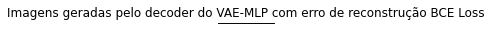

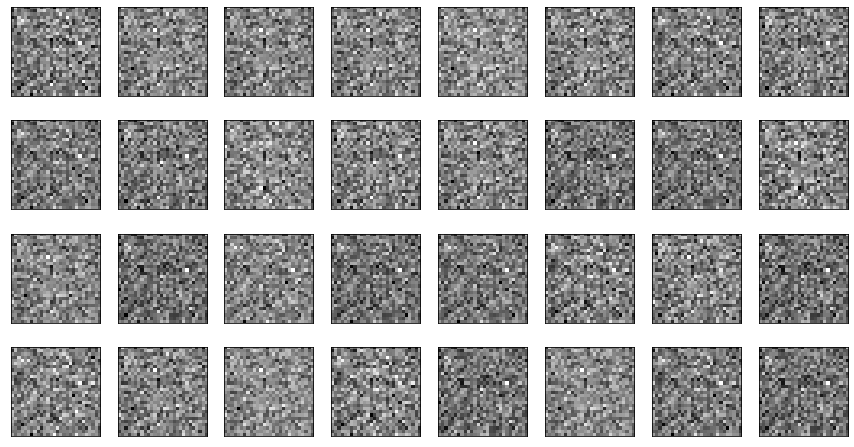

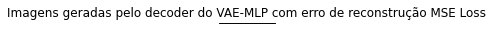

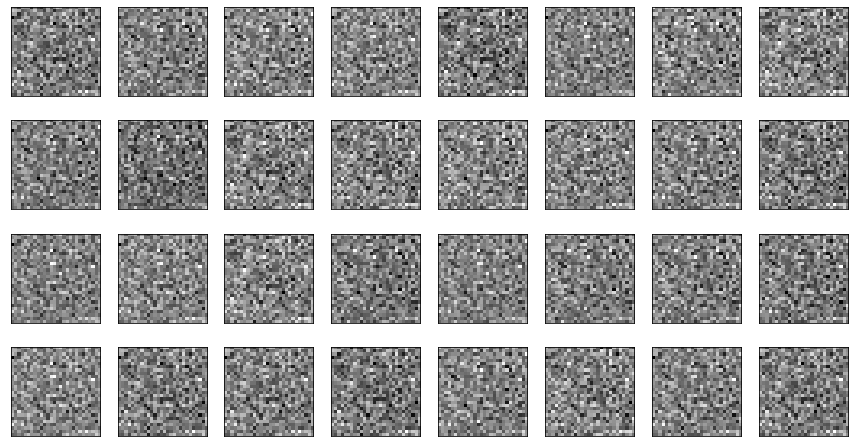

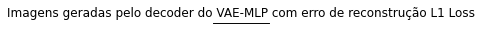

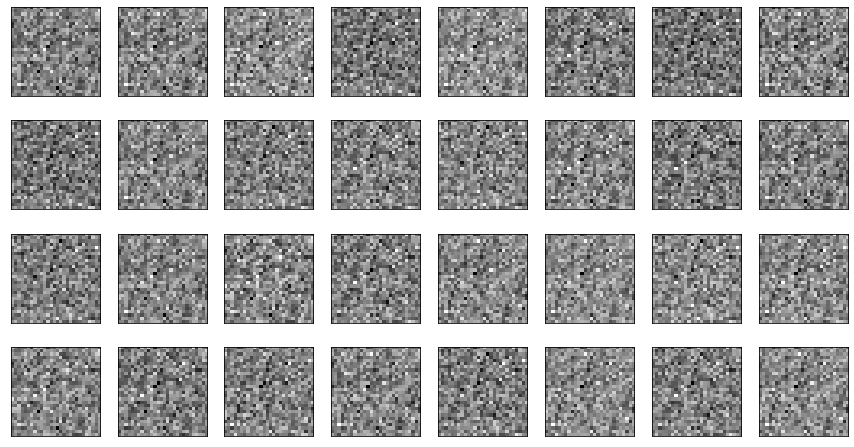

In [21]:
N = 0
for CRITERION1, MLP_VAE in zip(criterion_names, MLP_VAEs): 
    gaussian_noise = torch.randn(BATCH_SIZE, LATENT_DIM)
    MLP_VAE.eval()
    decoder = MLP_VAE.decoder

    new_images = decoder(gaussian_noise.to(device))
    separa_imagens(N=N, hyperparam=CRITERION1, opt='criterion'); N += 1
    fig = plt.figure(num=N, figsize=(15, 8)); N += 1

    with torch.no_grad():
        for i, new_image in enumerate(new_images):
            fig.add_subplot(4, 8, i+1)
            plt.imshow(new_image.view(28, 28).cpu(), cmap='gray')
            plt.xticks([])
            plt.yticks([])

**Treinamento**

In [22]:
models = []
for MLP_VAE, criterion1, optimizer, criterion_name in zip(MLP_VAEs, criterions1, optimizers, criterion_names):
    info = 'Treinamento do VAE-MLP com erro de reconstrução ' + criterion_name
    info = info.center(len(info) + 40)
    print()
    print(len(info)*'=')
    print(info)
    print(len(info)*'=')
    main(train_dataloader=train_dataloader, 
         model=MLP_VAE,
         reconstruction_loss=criterion1,
         regularization_loss=criterion2,
         optimizer = optimizer,
         device=device,
         epoch=EPOCHS);
    models.append(MLP_VAE)


                    Treinamento do VAE-MLP com erro de reconstrução BCE Loss                    


---> Epoch_time: 13 s  -  step_time: 6.99 ms  -  train_loss: 0.2090 

---> Epoch_time: 12 s  -  step_time: 6.86 ms  -  train_loss: 0.1907 

---> Epoch_time: 13 s  -  step_time: 6.97 ms  -  train_loss: 0.1865 

---> Epoch_time: 12 s  -  step_time: 6.90 ms  -  train_loss: 0.1842 

---> Epoch_time: 13 s  -  step_time: 7.01 ms  -  train_loss: 0.1832 

---> Epoch_time: 13 s  -  step_time: 7.17 ms  -  train_loss: 0.1825 

---> Epoch_time: 14 s  -  step_time: 7.72 ms  -  train_loss: 0.1814 

---> Epoch_time: 14 s  -  step_time: 7.69 ms  -  train_loss: 0.1808 

---> Epoch_time: 13 s  -  step_time: 7.34 ms  -  train_loss: 0.1804 

---> Epoch_time: 13 s  -  step_time: 7.18 ms  -  train_loss: 0.1804 

---> Epoch_time: 13 s  -  step_time: 7.20 ms  -  train_loss: 0.1799 

---> Epoch_time: 13 s  -  step_time: 7.05 ms  -  train_loss: 0.1795 

---> Epoch_time: 13 s  -  step_time: 7.13 ms  -  train_loss: 0.1791 

---> Epoch_time: 13 s  -  step_time: 7.21 ms  -  train_loss: 0.1789 

---> Epoch_time: 13 s  -  step_time: 7.32 ms  -  train_loss: 0.1790 

---> Epoch_time: 13 s  -  step_time: 7.24 ms  -  train_loss: 0.1787 

---> Epoch_time: 13 s  -  step_time: 7.31 ms  -  train_loss: 0.1785 

---> Epoch_time: 13 s  -  step_time: 7.28 ms  -  train_loss: 0.1786 

---> Epoch_time: 13 s  -  step_time: 7.42 ms  -  train_loss: 0.1784 

---> Epoch_time: 13 s  -  step_time: 7.44 ms  -  train_loss: 0.1787 

---> Epoch_time: 13 s  -  step_time: 7.45 ms  -  train_loss: 0.1785 

---> Epoch_time: 13 s  -  step_time: 7.34 ms  -  train_loss: 0.1781 

---> Epoch_time: 13 s  -  step_time: 7.40 ms  -  train_loss: 0.1780 

---> Epoch_time: 13 s  -  step_time: 7.40 ms  -  train_loss: 0.1779 

---> Epoch_time: 13 s  -  step_time: 7.37 ms  -  train_loss: 0.1793 

---> Epoch_time: 13 s  -  step_time: 7.37 ms  -  train_loss: 0.1790 

---> Epoch_time: 13 s  -  step_time: 7.39 ms  -  train_loss: 0.1783 

---> Epoch_time: 13 s  -  step_time: 7.35 ms  -  train_loss: 0.1782 

---> Epoch_time: 13 s  -  step_time: 7.45 ms  -  train_loss: 0.1782 

---> Epoch_time: 14 s  -  step_time: 7.48 ms  -  train_loss: 0.1777 
                    Treinamento do VAE-MLP com erro de reconstrução MSE Loss                    


---> Epoch_time: 13 s  -  step_time: 7.33 ms  -  train_loss: 0.0504 

---> Epoch_time: 13 s  -  step_time: 7.37 ms  -  train_loss: 0.0440 

---> Epoch_time: 13 s  -  step_time: 7.39 ms  -  train_loss: 0.0424 

---> Epoch_time: 13 s  -  step_time: 7.37 ms  -  train_loss: 0.0416 

---> Epoch_time: 13 s  -  step_time: 7.32 ms  -  train_loss: 0.0411 

---> Epoch_time: 13 s  -  step_time: 7.42 ms  -  train_loss: 0.0407 

---> Epoch_time: 13 s  -  step_time: 7.39 ms  -  train_loss: 0.0405 

---> Epoch_time: 13 s  -  step_time: 7.42 ms  -  train_loss: 0.0404 

---> Epoch_time: 13 s  -  step_time: 7.42 ms  -  train_loss: 0.0401 

---> Epoch_time: 13 s  -  step_time: 7.42 ms  -  train_loss: 0.0400 

---> Epoch_time: 14 s  -  step_time: 7.49 ms  -  train_loss: 0.0398 

---> Epoch_time: 13 s  -  step_time: 7.44 ms  -  train_loss: 0.0396 

---> Epoch_time: 13 s  -  step_time: 7.44 ms  -  train_loss: 0.0396 

---> Epoch_time: 13 s  -  step_time: 7.42 ms  -  train_loss: 0.0395 

---> Epoch_time: 14 s  -  step_time: 7.48 ms  -  train_loss: 0.0394 

---> Epoch_time: 13 s  -  step_time: 7.39 ms  -  train_loss: 0.0394 

---> Epoch_time: 13 s  -  step_time: 7.42 ms  -  train_loss: 0.0395 

---> Epoch_time: 13 s  -  step_time: 7.44 ms  -  train_loss: 0.0393 

---> Epoch_time: 13 s  -  step_time: 7.45 ms  -  train_loss: 0.0392 

---> Epoch_time: 14 s  -  step_time: 7.57 ms  -  train_loss: 0.0391 

---> Epoch_time: 14 s  -  step_time: 7.55 ms  -  train_loss: 0.0390 

---> Epoch_time: 14 s  -  step_time: 7.70 ms  -  train_loss: 0.0390 

---> Epoch_time: 14 s  -  step_time: 7.55 ms  -  train_loss: 0.0390 

---> Epoch_time: 14 s  -  step_time: 7.51 ms  -  train_loss: 0.0389 

---> Epoch_time: 14 s  -  step_time: 7.50 ms  -  train_loss: 0.0390 

---> Epoch_time: 14 s  -  step_time: 7.57 ms  -  train_loss: 0.0390 

---> Epoch_time: 14 s  -  step_time: 7.52 ms  -  train_loss: 0.0389 

---> Epoch_time: 14 s  -  step_time: 7.53 ms  -  train_loss: 0.0388 

---> Epoch_time: 14 s  -  step_time: 7.60 ms  -  train_loss: 0.0391 

---> Epoch_time: 14 s  -  step_time: 7.49 ms  -  train_loss: 0.0388 
                    Treinamento do VAE-MLP com erro de reconstrução L1 Loss                    


---> Epoch_time: 14 s  -  step_time: 7.61 ms  -  train_loss: 0.1026 

---> Epoch_time: 14 s  -  step_time: 7.58 ms  -  train_loss: 0.0914 

---> Epoch_time: 14 s  -  step_time: 7.74 ms  -  train_loss: 0.0882 

---> Epoch_time: 14 s  -  step_time: 7.64 ms  -  train_loss: 0.0865 

---> Epoch_time: 14 s  -  step_time: 7.65 ms  -  train_loss: 0.0853 

---> Epoch_time: 14 s  -  step_time: 7.69 ms  -  train_loss: 0.0842 

---> Epoch_time: 14 s  -  step_time: 7.71 ms  -  train_loss: 0.0834 

---> Epoch_time: 14 s  -  step_time: 7.64 ms  -  train_loss: 0.0826 

---> Epoch_time: 14 s  -  step_time: 7.63 ms  -  train_loss: 0.0819 

---> Epoch_time: 14 s  -  step_time: 7.66 ms  -  train_loss: 0.0815 

---> Epoch_time: 14 s  -  step_time: 7.68 ms  -  train_loss: 0.0810 

---> Epoch_time: 14 s  -  step_time: 7.61 ms  -  train_loss: 0.0806 

---> Epoch_time: 14 s  -  step_time: 7.72 ms  -  train_loss: 0.0804 

---> Epoch_time: 14 s  -  step_time: 7.87 ms  -  train_loss: 0.0801 

---> Epoch_time: 14 s  -  step_time: 7.67 ms  -  train_loss: 0.0799 

---> Epoch_time: 14 s  -  step_time: 7.70 ms  -  train_loss: 0.0798 

---> Epoch_time: 14 s  -  step_time: 7.62 ms  -  train_loss: 0.0795 

---> Epoch_time: 14 s  -  step_time: 7.75 ms  -  train_loss: 0.0792 

---> Epoch_time: 14 s  -  step_time: 7.58 ms  -  train_loss: 0.0790 

---> Epoch_time: 14 s  -  step_time: 7.64 ms  -  train_loss: 0.0790 

---> Epoch_time: 14 s  -  step_time: 7.59 ms  -  train_loss: 0.0787 

---> Epoch_time: 14 s  -  step_time: 7.68 ms  -  train_loss: 0.0785 

---> Epoch_time: 14 s  -  step_time: 7.63 ms  -  train_loss: 0.0784 

---> Epoch_time: 14 s  -  step_time: 7.85 ms  -  train_loss: 0.0783 

---> Epoch_time: 14 s  -  step_time: 7.66 ms  -  train_loss: 0.0782 

---> Epoch_time: 14 s  -  step_time: 7.69 ms  -  train_loss: 0.0780 

---> Epoch_time: 14 s  -  step_time: 7.71 ms  -  train_loss: 0.0780 

---> Epoch_time: 14 s  -  step_time: 7.67 ms  -  train_loss: 0.0778 

---> Epoch_time: 14 s  -  step_time: 7.71 ms  -  train_loss: 0.0777 

---> Epoch_time: 14 s  -  step_time: 7.65 ms  -  train_loss: 0.0777 

**Exemplos de imagens reconstruídas**

A figura abaixo mostra um batch de treinamento com imagens reconstruídas pelos autoencoders variacionais treinados.

Como o espaço latente tem dimensão 2 nenhum dos 3 modelos treinados foram capazes de reconstruir bem as imagens de entrada.

Além disso, podemos observar que as imagens reconstruídas pelos autoencoders variacionais treinados com erros de reconstrução *BCE Loss* e *MSE Loss* estão muito embaçadas, enquanto que as imagens reconstruídas pelo autoencoder variacional treinado com erro de reconstrução *L1 Loss* estão bem nítidas. 



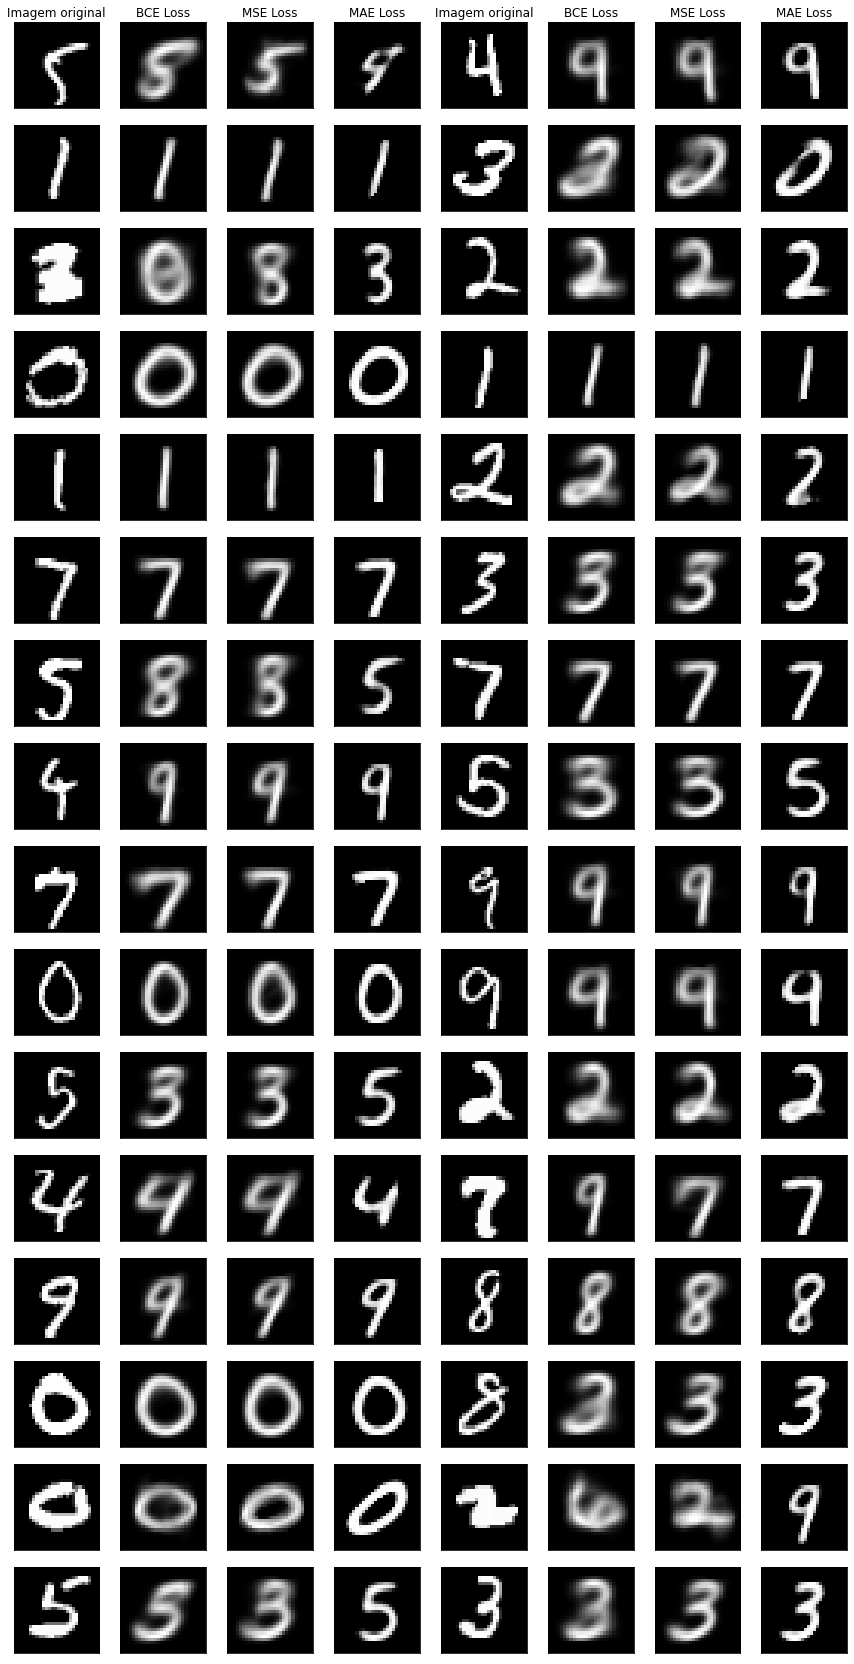

In [23]:
images_examples, labels_example = next(iter(train_dataloader))
images = images_examples.squeeze(1).view(images_examples.shape[0], -1).to(device)

MLP_VAEs[0].eval()
MLP_VAEs[1].eval()
MLP_VAEs[2].eval()
reconstructions = [reconstruction for reconstruction, _, _ in [MLP_VAE(images) for MLP_VAE in models]]

x = []
for i in range(32):
    x.append(images[i])
    for j in range(3):
        x.append(reconstructions[j][i])

fig = plt.figure(figsize=(15, 30))
with torch.no_grad():
    k = 0
    for i, image in zip(range(128), x):
        fig.add_subplot(16, 8, i+1)
        plt.imshow(image.view(28, 28).cpu(), cmap='gray')
        if i < 8:
            if k == 0:
                plt.title('Imagem original')
                k = 1
            elif k == 1:
                plt.title('BCE Loss')
                k = 2
            elif k == 2:
                plt.title('MSE Loss')
                k = 3
            else:
                plt.title('MAE Loss')
                k = 0
        plt.xticks([]); plt.yticks([])

**Funcionamento do decoder após o treinamento**

A figura abaixo apresenta imagens geradas pelos decodificadores (modelos generativos) obtidos pelo processo de treinamento quando submetidos à ruídos gaussianos de média zero e variância unitária.

Assim como no caso das imagens de treinamento reconstruídas, podemos observar que as novas imagens produzidas pelos modelos generativos associados aos autoencoders variacionais treinados com erros de reconstrução *BCE Loss* e *MSE Loss* estão bastante embaçadas, enquanto que as novas imagens produzidas pelo modelo generativo associado ao autoencoder variacional treinado com erro de reconstrução *L1 Loss* estão bem nítidas.

Portanto, podemos concluir que o uso da função *L1 Loss* para o erro de reconstrução se mostra mais interessante pois produz as imagens mais similares aos do dataset.

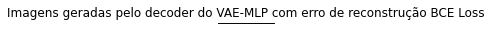

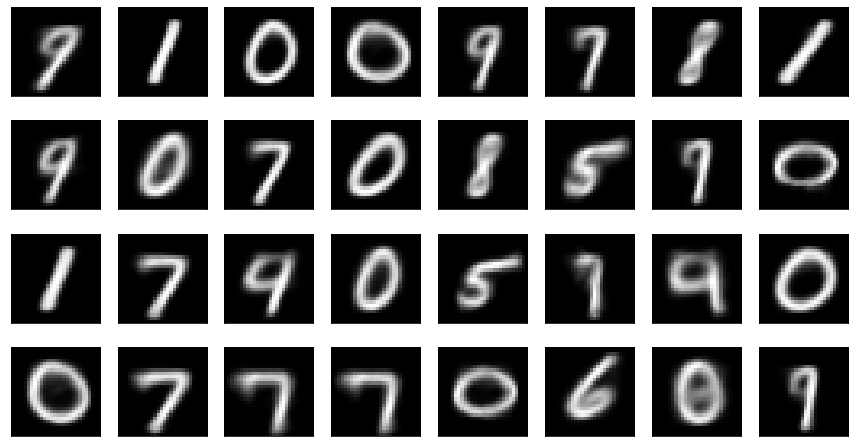

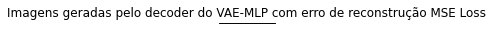

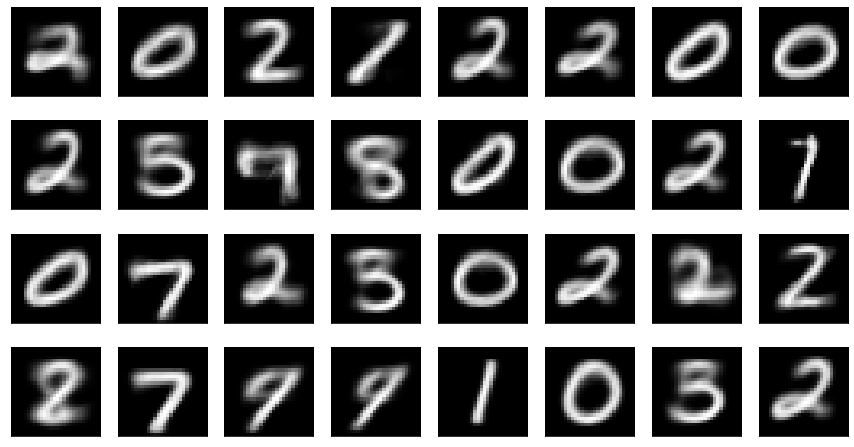

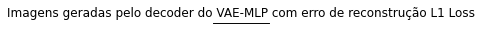

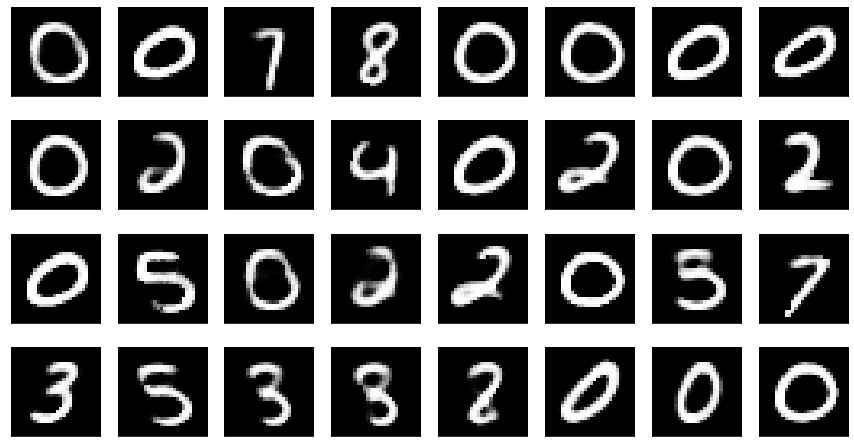

In [24]:
gaussian_noise = torch.randn(BATCH_SIZE, LATENT_DIM)

N = 0
for name, MLP_VAE in zip(criterion_names, models):
    MLP_VAE.eval() 
    decoder = MLP_VAE.decoder

    new_images = decoder(gaussian_noise.to(device))
    image = new_images.view(32, 28, 28).cpu()
    
    separa_imagens(N=N, hyperparam=name, opt='criterion'); N += 1
    fig = plt.figure(num=N, figsize=(15, 8)); N += 1

    with torch.no_grad():
        for i, new_image in enumerate(new_images):
            fig.add_subplot(4, 8, i+1)
            plt.imshow(new_image.view(28, 28).cpu(), cmap='gray')
            plt.xticks([])
            plt.yticks([])

### **Análise - Manifold**

**Instância do modelo, da função custo e do otimizador**

Após determinar os melhores hiperparâmetros, espaço latente de dimensão 2 e erro de reconstrução com função *L1 Loss*, investigaremos o *manifold* aprendido pelo modelo.

In [25]:
INPUT_DIM = 784
LATENT_DIM = 2
EPOCHS = 50
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

MLP_VAE = VariationalAutoencoderMLP(in_features=INPUT_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(MLP_VAE.parameters())
criterion1 = nn.L1Loss()
criterion2 = KLDLoss

**Treinamento**

Primeiro treinamos o nosso modelo da mesma forma que foi feito nas seções anteriores.

In [31]:
# Treinamento
info = 'Treinamento do VAE-MLP com espaço latente de dimensão 2 e erro de reconstrução L1 Loss'
info = info.center(len(info) + 20)
print()
print(len(info)*'=')
print(info)
print(len(info)*'=')
train_losses = main(train_dataloader=train_dataloader, 
                    model=MLP_VAE,
                    reconstruction_loss=criterion1,
                    regularization_loss=criterion2,
                    optimizer = optimizer,
                    device=device,
                    epoch=EPOCHS)

# Salva o modelo:
PATH = '/content/gdrive/MyDrive/01 - Mestrado/Materiais de Estudo/Notebooks/Modelos'
NAME = '/MLP_VAE_MNIST.pt'
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': MLP_VAE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses
}, f=PATH+NAME)

**Códigos das imagens de entrada de treinamento**

Para visualizar o *manifold* precisamos amostrar pontos do espaço latente de dimensão 2 correspondentes às imagens de treinamento. 

Para isso, passamos todas as amostras de entrada pelo codificador do modelo e, em seguida, amostramos os códigos (pontos do espaço latente) de uma distribuição normal padrão com o módulo *Reparametrization Trick*.

In [32]:
# Um batch com todas as 55000 amostras de treinamento
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

# Ativamos o modelo no modo evaluate por causa do dropout:
MLP_VAE.eval()
images, labels = next(iter(train_dataloader))
images = images.squeeze(1).view(images.shape[0], -1).to(device)
means, logvars = MLP_VAE.encoder(images)        # obtemos as médias e o log das variâncias
coding_space = MLP_VAE.sampling(means, logvars) # obtemos o código

coding_space = coding_space.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()

print('coding_space.shape  : ', coding_space.shape)
print('labels.shape        : ', labels.shape)

coding_space.shape  :  (60000, 2)
labels.shape        :  (60000,)


**Visualização do manifold**
  

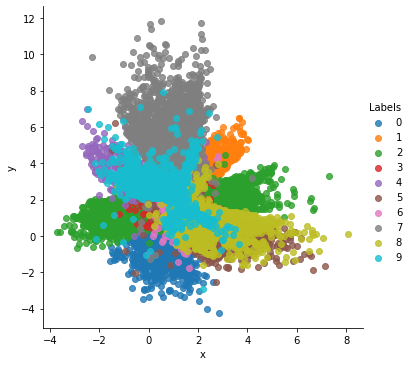

In [33]:
proj = pd.DataFrame(coding_space)
proj.columns = ["x", "y"]
proj["Labels"] = labels
sns_plot = sns.lmplot(x="x", y="y", hue="Labels", data=proj, fit_reg=False);

**Geração de novas imagens com o decodificador**

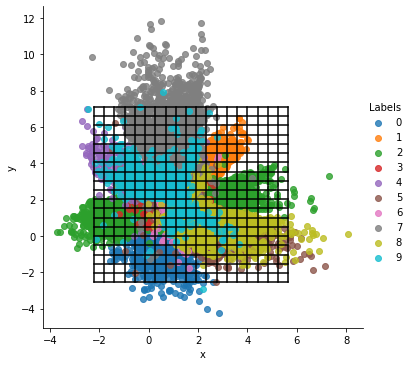

In [34]:
x_max, y_max = np.max(coding_space, axis=0)
x_min, y_min = np.min(coding_space, axis=0)

x_max, y_max = 0.7 * x_max, 0.6 * y_max
x_min, y_min = 0.6 * x_min, 0.6 * y_min


_ = sns.lmplot(x="x", y="y", hue="Labels", data=proj, fit_reg=False)

all_x1 = [x_min + (x_max - x_min) * i / 19 for i in range(20)]
all_y2 = [y_min + (y_max - y_min) * i / 19 for i in range(20)]

for j in range(0, 20):

    all_y1 = [y_min + (y_max - y_min) * j / 19 for k in range(20)]
    all_x2 = [x_min + (x_max - x_min) * j / 19 for k in range(20)]

    plt.plot(all_x1, all_y1, 'black')
    plt.plot(all_x2, all_y2, 'black')

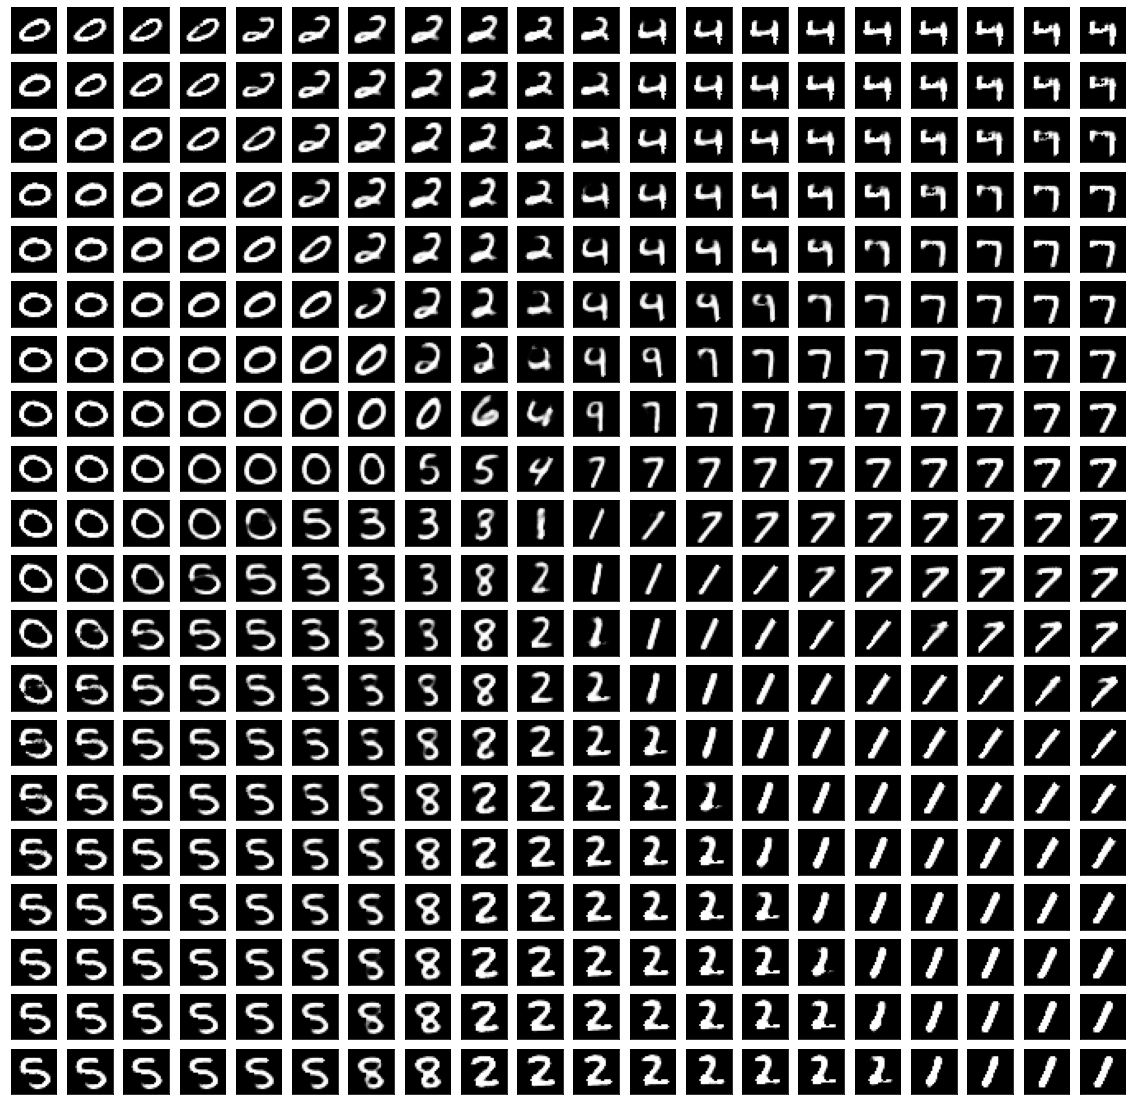

In [35]:
# moving along a grid:
fig = plt.figure(figsize=(20, 20))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        
        pt = torch.from_numpy(np.array([[ x_min + (x_max - x_min) * i / 19, y_min + (y_max - y_min) * j / 19]]))
        pt = pt.float()
        _ = plt.imshow(MLP_VAE.decoder(pt.to(device)).detach().view(28, 28).cpu(), cmap='gray')
        _ = plt.xticks([])
        _ = plt.yticks([])

PATH = '/content/gdrive/MyDrive/01 - Mestrado/Materiais de Estudo/Notebooks/MNIST Imagens Geradas'
FIG_NAME = '/VAE_MLP_MNIST_MANIFOLD.png'
fig.savefig(fname=PATH+FIG_NAME)

### **Conclusões**

Neste *notebook* investigamos como a dimensão do espaço latente e o tipo de erro de reconstrução utilizado no treinamento impactam na qualidade das imagens reconstruídas pelo autoencoder variacional e  das novas imagens produzidas pelo modelo generativo (apenas o decodificador).

Para esta investigação, treinamos autoencoders variacionais com espaços latentes de dimensões iguais a 2, 10 e 50 e, após determinar o melhor valor para este hiperparâmetro, treinamos autoencoders variacionais com erros de reconstrução *BCE Loss*, *MSE Loss* e *L1 Loss*.

Com relação à dimensão do espaço latente, vimos que:
- As imagens de entrada são melhor reconstruídas com os autoencoders variacionais com espaço latente de maior dimensão (10 e 50). Em contra-partida, o modelo generativo referente ao autoencoder variacional com espaço latente de dimensão 2 produziu imagens mais similares aos do *dataset* do que àqueles com maior dimensão.
- Logo, o modelo com dimensão 2 aprendeu melhor a mapear a distribuição que gera os dados de treino, mesmo produzindo imagens mais embaçadas. Como o objetivo final do autoencoder variacional não é a reconstrução de imagens já existentes, mas sim a geração de novas imagens, concluímos que o autoencoder variacional com espaço latente de dimensão 2 é o melhor.

Com relação à função custo utilizada no erro de reconstrução, vimos que:
- As funções *BCE Loss* e *MSE Loss* resultaram em modelos que produziram imagens reconstruídas e imagens sintéticas de baixa resolução (as imagens estão pouco nítidas). Por outro lado, o autoencoder variacional treinado com *L1 Loss* foi capaz de gerar imagens de ótima qualidade.
- A seguir apresentamos uma possível explicação para o aumento de qualidade das imagens quando o modelo é treinado com a função *L1 Loss*.
  - Os pixels das imagens de entrada, os quais tentamos gerar durante o treinamento, estão no intervalo [0, 1].
  - Para os pixels da imagem de entrada que são iguais a 0 e iguais a 1, o erro dado pela diferença entre esses valores e os pixels preditos pelo modelo é maior quando as funções *BCE Loss* e *MSE Loss* são utilizadas.
  - Contudo, para os pixels com valores intermediários, que estão entre 0 e 1, o erro é maior quando a função *L1 Loss* é utilizada. Este comportamento é ainda mais acentuado quando os pixels alvo e predito estão próximos, mas ainda distintos. 
  - Com um erro maior, os pesos são ajustados de forma mais acentuada com a função *L1 Loss* e, consequentemente, o modelo tende a produzir imagens mais nítidas.   





